# Behavioral Cloning Project

In [1]:
import argparse
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

/Users/fc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
class Model:
    __IMAGE_HEIGHT=66
    __IMAGE_WIDTH=200
    __IMAGE_CHANNEL=3
    __INPUT_SHAPE = (__IMAGE_HEIGHT, __IMAGE_WIDTH, __IMAGE_CHANNEL)
        
    def __init__(self, *args):
        if args:
            parse_args = args[0]
            self.data_dir = parse_args.data_dir
            self.train_test_split = parse_args.train_test_split
            self.dropout = parse_args.dropout
            self.epoch = parse_args.epoch
            self.batch_size = parse_args.batch_size
            self.steps_per_epoch = parse_args.steps_per_epoch
            self.batch_size = parse_args.batch_size
            self.learning_rate = parse_args.learning_rate
            self.save_best_only = True
        else:
            self.data_dir = 'data'
    
    def load_csv(self):
        """
        Load csv file and split it into training and validation set

        """
        data_df = pd.read_csv(os.path.join(self.data_dir, 'driving_log.csv'))

        X = data_df[['center', 'left', 'right']].values
        y = data_df['steering'].values

        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=self.train_test_split, random_state=0)

    def build_model(self):
        """
        Build model network architecture

        """
        model = Sequential()
        model.add(Lambda(lambda x: x/127.5-1.0, input_shape=self.__INPUT_SHAPE))
        model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
        model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
        model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
        model.add(Conv2D(64, 3, 3, activation='elu'))
        model.add(Conv2D(64, 3, 3, activation='elu'))
        model.add(Dropout(self.dropout))
        model.add(Flatten())
        model.add(Dense(100, activation='elu'))
        model.add(Dense(50, activation='elu'))
        model.add(Dense(10, activation='elu'))
        model.add(Dense(1))
        model.summary()
        self.model = model
    
    def load_image(self, filename):
        """
        Load RGB images from a file

        """
        return mpimg.imread(os.path.join(self.data_dir, filename.strip()))

    def img_crop(self, img):
        """
        Crop the image (removing the sky at the top and the car front at the bottom).
        
        """
        return img[60:-25, :, :] # remove the sky and the car front

    def img_resize(self, img):
        """
        Resize the image to the input shape used by the network model
        
        """
        return cv2.resize(img, (self.__IMAGE_WIDTH, self.__IMAGE_HEIGHT), cv2.INTER_AREA)

    def img_rgb2yuv(self, img):
        """
        Convert the image from RGB to YUV (This is what the NVIDIA model does)

        """
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    def img_preprocess(self, img):
        """
        Combine all preprocess functions into one

        """
        img = self.img_crop(img)
        img = self.img_resize(img)
        img = self.img_rgb2yuv(img)
        return img

    def __random_choose_image(self, center, left, right, steering_angle):
        """
        Randomly choose an image from the center, left or right, and adjust
        the steering angle.

        """
        choice = np.random.choice(3)
        if choice == 0:
            return self.load_image(left), steering_angle + 0.2
        elif choice == 1:
            return self.load_image(right), steering_angle - 0.2
        return self.load_image(center), steering_angle

    def img_random_flip(self, img, steering_angle):
        """
        Randomly flip the image left <-> right, and adjust the steering angle.

        """
        if np.random.rand() < 0.5:
            img = cv2.flip(img, 1)
            steering_angle = -steering_angle
        return img, steering_angle
    
    def img_random_shift(self, img, steering_angle, range_x=100, range_y=10):
        """
        Randomly shift the image virtically and horizontally.

        """
        shift_x = range_x * (np.random.rand() - 0.5)
        shift_y = range_y * (np.random.rand() - 0.5)
        steering_angle += shift_x * 0.002
        m = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        height, width = img.shape[:2]
        img = cv2.warpAffine(img, m, (width, height))
        return img, steering_angle

    def img_random_rotate(self, img, steering_angle, angle=30):
        """
        Randomly rotate the image.

        """
        tilt = np.random.randint(-1*angle, angle+1)
        height, width = img.shape[:2]
        M = cv2.getRotationMatrix2D((height/2, width/2), tilt, 1)
        img = cv2.warpAffine(img, M, (width, height))
        steering_angle += steering_angle * float(tilt/360)*0.001
        return img, steering_angle
    
    def img_random_shadow(self, img):
        """
        Generates and adds random shadow.

        """
        # (x1, y1) and (x2, y2) forms a line
        # xm, ym gives all the locations of the image
        x1, y1 = img.shape[1] * np.random.rand(), 0
        x2, y2 = img.shape[1] * np.random.rand(), img.shape[0]
        xm, ym = np.mgrid[0:img.shape[0], 0:img.shape[1]]

        # mathematically speaking, we want to set 1 below the line and zero otherwise
        # Our coordinate is up side down.  So, the above the line: 
        # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
        # as x2 == x1 causes zero-division problem, we'll write it in the below form:
        # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
        mask = np.zeros_like(img[:, :, 1])
        mask[(ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0] = 1

        # choose which side should have shadow and adjust saturation
        cond = mask == np.random.randint(2)
        s_ratio = np.random.uniform(low=0.2, high=0.5)

        # adjust Saturation in HLS(Hue, Light   , Saturation)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
        return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

    def img_random_brightness(self, img):
        """
        Randomly adjust brightness of the image.
        
        """
        # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
        hsv[:,:,2] =  hsv[:,:,2] * ratio
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    def __augment(self, center, left, right, steering_angle):
        """
        Generate an augmented image and adjust steering angle.
        (The steering angle is associated with the center image)

        """
        img, steering_angle = self.__random_choose_image(center, left, right, steering_angle)
        img, steering_angle = self.img_random_flip(img, steering_angle)
        img, steering_angle = self.img_random_shift(img, steering_angle)
        img, steering_angle = self.img_random_rotate(img, steering_angle)
        img = self.img_random_shadow(img)
        img = self.img_random_brightness(img)
        return img, steering_angle

    def __batch_generator(self, filenames, steering_angles, is_training):
        """
        Generate training/validation image batch given image paths and associated steering angles.
        
        """
        imgs = np.empty([self.batch_size, self.__IMAGE_HEIGHT, self.__IMAGE_WIDTH, self.__IMAGE_CHANNEL])
        steers = np.empty(self.batch_size)
        while True:
            i = 0
            for index in np.random.permutation(filenames.shape[0]):
                center, left, right = filenames[index]
                steering_angle = steering_angles[index]
                # augmentation
                if is_training and np.random.rand() < 0.6:
                    img, steering_angle = self.__augment(center, left, right, steering_angle)
                else:
                    img = self.load_image(center) 
                # add the image and steering angle to the batch
                imgs[i] = self.img_preprocess(img)
                steers[i] = steering_angle
                i += 1
                if i == self.batch_size:
                    break
            yield imgs, steers

    def train(self):
        """
        Train the model
        """
        checkpoint = ModelCheckpoint(
            'model-{epoch:03d}.h5',
            monitor='val_loss',
            verbose=0,
            save_best_only=self.save_best_only,
            mode='auto'
        )

        self.model.compile(
            loss='mean_squared_error',
            optimizer=Adam(lr=self.learning_rate)
        )

        self.model.fit_generator(
            self.__batch_generator(self.X_train, self.y_train, True),
            self.steps_per_epoch,
            self.epoch,
            max_q_size=1,
            validation_data=self.__batch_generator(self.X_valid, self.y_valid, False),
            nb_val_samples=len(self.X_valid),
            callbacks=[checkpoint],
            verbose=1
        )


In [86]:
import matplotlib.pyplot as plt

IMAGE = 'IMG/center_2016_12_01_13_31_15_513.jpg'
steering_angle = 0

AUG_IMAGE = 'images/aug.jpg'
PRE_IMAGE = 'images/pre.jpg'

## Data Augmentation

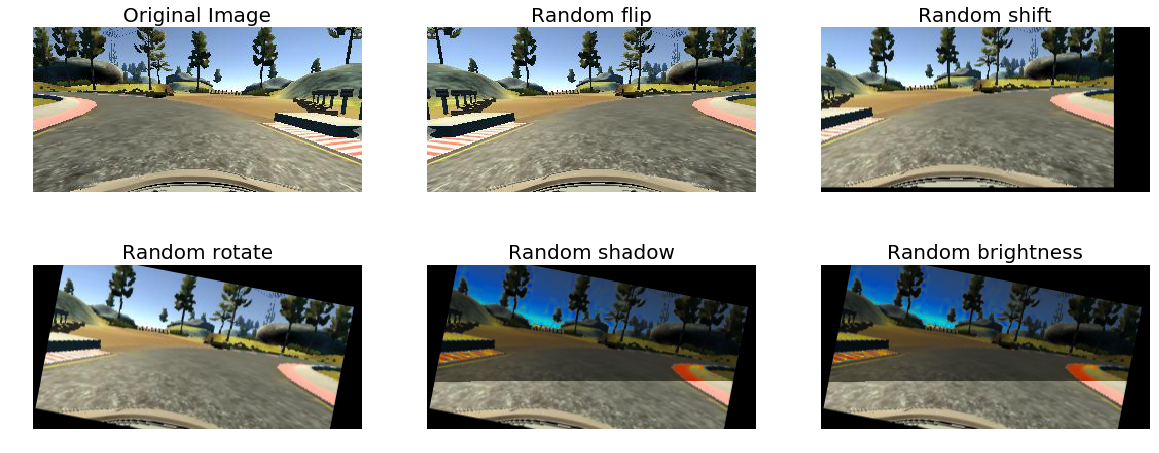

In [84]:
model = Model()

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20, 8))

img = model.load_image(IMAGE)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax1.axis('off')

img, steering_angle = model.img_random_flip(img, 0.1)
ax2.imshow(img)
ax2.set_title('Random flip', fontsize=20)
ax2.axis('off')

img, steering_angle = model.img_random_shift(img, steering_angle)
ax3.imshow(img)
ax3.set_title('Random shift', fontsize=20)
ax3.axis('off')

img, steering_angle = model.img_random_rotate(img, steering_angle)
ax4.imshow(img)
ax4.set_title('Random rotate', fontsize=20)
ax4.axis('off')

img = model.img_random_shadow(img)
ax5.imshow(img)
ax5.set_title('Random shadow', fontsize=20)
ax5.axis('off')

ax6.imshow(img)
ax6.set_title('Random brightness', fontsize=20)
ax6.axis('off')

plt.show()
f.savefig(AUG_IMAGE)

## Data Preprocess

### Locad Image

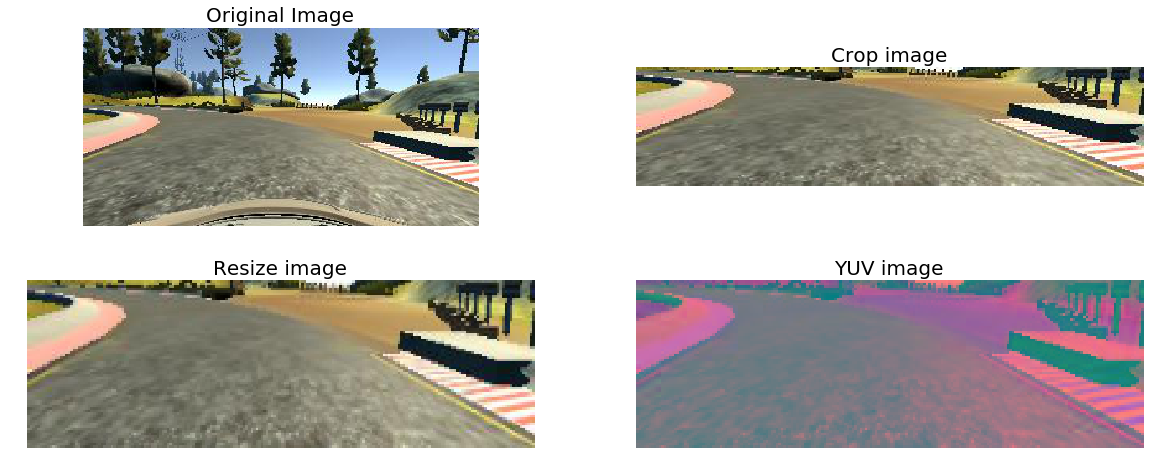

In [90]:
model = Model()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 8))

img = model.load_image(IMAGE)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax1.axis('off')

img = model.img_crop(img)
ax2.imshow(img)
ax2.set_title('Crop image', fontsize=20)
ax2.axis('off')

img = model.img_resize(img)
ax3.imshow(img)
ax3.set_title('Resize image', fontsize=20)
ax3.axis('off')

img = model.img_rgb2yuv(img)
ax4.imshow(img)
ax4.set_title('YUV image', fontsize=20)
ax4.axis('off')

plt.show()
f.savefig(PRE_IMAGE)

### Convert from RGB to YUV color space

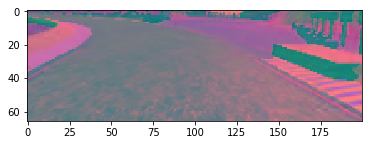

In [13]:
img = model.img_rgb2yuv(img)
plt.imshow(img)
plt.imsave(YUV_IMAGE, img)